# Certificate in Data Science | Assignment 8 |  
- Regression Simulation 

> University of Washington  
> September 2019  
> N. HICKS

## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


Note:  
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Import Libraries

In [3]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.tsa.seasonal as sts
import statsmodels.graphics.tsaplots as splt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from scipy.stats import zscore
import sklearn.linear_model as lm
from math import sqrt
import scipy.stats as ss

## Variables & Functions

In [4]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 7]   # set for all notebook; width, height of the resulting plots
sns.set()

In [5]:
# retrieve the prescribed dataset
def fetch_data(path, file):
    try:
        # import the file to a dataframe
        _df = pd.read_csv(path+file, index_col=0)
        print('REMOTE FILE USED')
    except:
        # Local Copy -- Link would not permit access
        path = 'C://Users//NateDogg//Desktop//_notebooks//'
        print('LOCAL FILE USED; REMOTE SERVER NOT REACHABLE\n--> [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:590)\n\n')
        # import the file to a dataframe
        _df = pd.read_csv(path+file, index_col=0)
    
    return _df

In [6]:
# establish a time series plot of the time series data
def plot_ts(ts, title):
    ts.plot()
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')

In [7]:
# decompose the time series
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    ax = res.plot()
    return (pd.DataFrame({'resid': res.resid,
                          'trend': res.trend,
                          'seasonal': res.seasonal},
                         index = ts.index)
           )

In [8]:
# evaluate if the time series data is stationary or not
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))

In [9]:
# the ARIMA processor
def model_ARIMA_2(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima_model import ARIMAResults    
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

# helper function to the ARIMA processor
def step_ARIMA(resid, p_max, d_max, q_max):
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

In [10]:
# plot the forecasted feature
def plot_mod_fit(df, col):
    fig = plt.figure()
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual vs. Predictions - {}'.format(col)) # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
    ax.legend()

In [11]:
def RMSE(ts, score):
    return sqrt(np.std(ts - score))

In [12]:
def dist_ts(ts, lab = '', bins = 40):
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2)
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)

## Import & View the Dataset

In [14]:
path = 'https://library.startlearninglabs.uw.edu//DATASCI410//Datasets//'
file = 'CADairyProduction.csv'
dairy_df = fetch_data(path, file)
dairy_df.info()

LOCAL FILE USED; REMOTE SERVER NOT REACHABLE
--> [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:590)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 1995 to 2013
Data columns (total 8 columns):
Month                228 non-null object
Cotagecheese.Prod    228 non-null float64
Icecream.Prod        228 non-null float64
Milk.Prod            228 non-null float64
N.CA.Fat.Price       228 non-null float64
Month.Count          228 non-null int64
monthNumSqred        228 non-null int64
monthNumCubed        228 non-null int64
dtypes: float64(4), int64(3), object(1)
memory usage: 16.0+ KB


In [15]:
dairy_df['Month']


Year
1995    Jan
1995    Feb
1995    Mar
1995    Apr
1995    May
1995    Jun
1995    Jul
1995    Aug
1995    Sep
1995    Oct
1995    Nov
1995    Dec
1996    Jan
1996    Feb
1996    Mar
1996    Apr
1996    May
1996    Jun
1996    Jul
1996    Aug
1996    Sep
1996    Oct
1996    Nov
1996    Dec
1997    Jan
1997    Feb
1997    Mar
1997    Apr
1997    May
1997    Jun
       ... 
2011    Jul
2011    Aug
2011    Sep
2011    Oct
2011    Nov
2011    Dec
2012    Jan
2012    Feb
2012    Mar
2012    Apr
2012    May
2012    Jun
2012    Jul
2012    Aug
2012    Sep
2012    Oct
2012    Nov
2012    Dec
2013    Jan
2013    Feb
2013    Mar
2013    Apr
2013    May
2013    Jun
2013    Jul
2013    Aug
2013    Sep
2013    Oct
2013    Nov
2013    Dec
Name: Month, Length: 228, dtype: object

In [20]:
# establish the time series index values
dairy_df.index = pd.date_range(start = '1-1-1995', end = '12-31-2013', freq = 'M')
print(dairy_df.head())
print(dairy_df.tail())

           Month  Cotagecheese.Prod  Icecream.Prod  Milk.Prod  N.CA.Fat.Price  \
1995-01-31   Jan              4.370         51.595      2.112          0.9803   
1995-02-28   Feb              3.695         56.086      1.932          0.8924   
1995-03-31   Mar              4.538         68.453      2.162          0.8924   
1995-04-30   Apr              4.280         65.722      2.130          0.8967   
1995-05-31   May              4.470         73.730      2.227          0.8967   

            Month.Count  monthNumSqred  monthNumCubed  
1995-01-31            1              1              1  
1995-02-28            2              4              8  
1995-03-31            3              9             27  
1995-04-30            4             16             64  
1995-05-31            5             25            125  
           Month  Cotagecheese.Prod  Icecream.Prod  Milk.Prod  N.CA.Fat.Price  \
2013-08-31   Aug              2.169         78.382      3.400          1.6273   
2013-09-30   Se

## Plot Initial Data

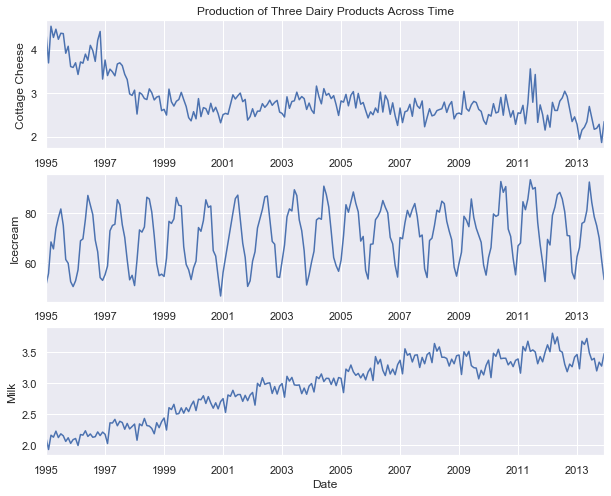

In [59]:
figArea = (10,8)   # width, height of the resulting plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
dairy_df['Cotagecheese.Prod'].plot(ax = ax1, figsize=figArea)
dairy_df['Icecream.Prod'].plot(ax = ax2)
dairy_df['Milk.Prod'].plot(ax = ax3)
ax1.set_ylabel('Cottage Cheese')
ax2.set_ylabel('Icecream')
ax3.set_ylabel('Milk')
ax3.set_xlabel('Date')
ax1.set_title('Production of Three Dairy Products Across Time')
plt.show()

## Evaluate a Single Feature - Milk Production

Index(['Month', 'Cotagecheese.Prod', 'Icecream.Prod', 'Milk.Prod',
       'N.CA.Fat.Price', 'Month.Count', 'monthNumSqred', 'monthNumCubed',
       'milk_log'],
      dtype='object')

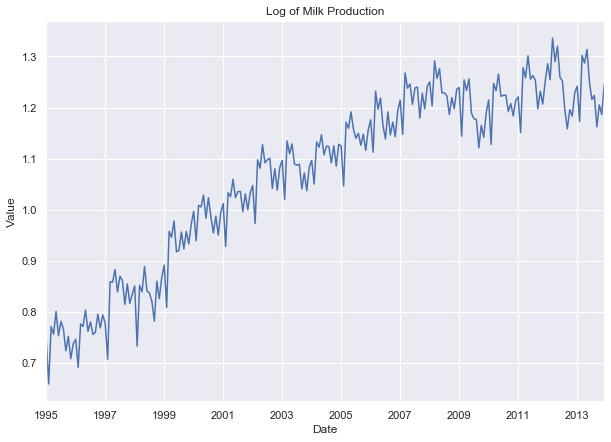

In [58]:
dairy_df['milk_log'] = np.log(dairy_df['Milk.Prod'])
plot_ts(dairy_df.milk_log, 'Log of Milk Production')
dairy_df.columns

## Decompose the Time Series - Milk Production

               resid     trend  seasonal
1995-01-31       NaN       NaN  0.009169
1995-02-28       NaN       NaN -0.063646
1995-03-31       NaN       NaN  0.046570
1995-04-30       NaN       NaN  0.026694
1995-05-31       NaN       NaN  0.053586
1995-06-30       NaN       NaN  0.004263
1995-07-31  0.026259  0.746283  0.008616
1995-08-31  0.016510  0.747581  0.002307
1995-09-30  0.014267  0.749151 -0.039741
1995-10-31  0.008047  0.750003 -0.006162
1995-11-30 -0.003504  0.750755 -0.039215
1995-12-31 -0.011135  0.751219 -0.002441
               resid     trend  seasonal
2013-01-31  0.002499  1.230179  0.009169
2013-02-28  0.006582  1.229856 -0.063646
2013-03-31  0.024035  1.231219  0.046570
2013-04-30  0.028554  1.231778  0.026694
2013-05-31  0.027831  1.232307  0.053586
2013-06-30  0.012240  1.233112  0.004263
2013-07-31       NaN       NaN  0.008616
2013-08-31       NaN       NaN  0.002307
2013-09-30       NaN       NaN -0.039741
2013-10-31       NaN       NaN -0.006162
2013-11-30      

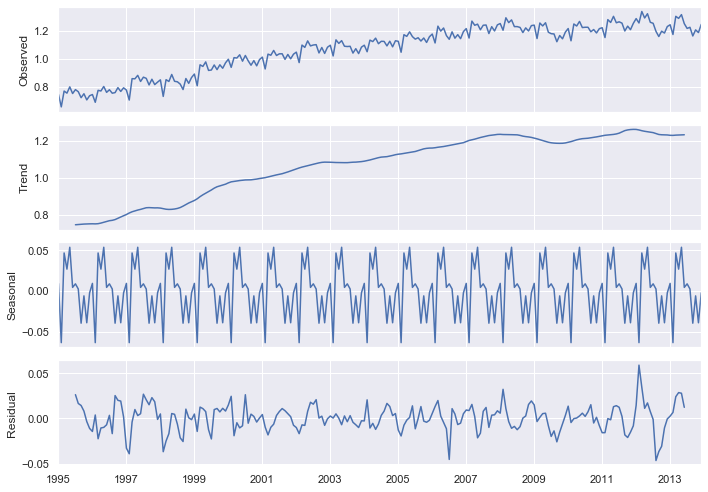

In [76]:
# decompose the time series 'Milk.Prod'
milk_decomp = decomp_ts(dairy_df.milk_log)
print(milk_decomp.head(12))
print(milk_decomp.tail(12))

## Verify the Time Series is Stationary  
> - Given the results below, the null hypothesis that the time series is not stationary is rejected.  
> - Therefor, application of an auto-regressive model is permissible.

In [83]:
DF_Test(milk_decomp.resid[6:-6])

D-F statistic = -8.280935682685257
p-value = 4.521792223864646e-13
number of lags used = 7
Critical value at 5% confidence = -2.875537986778846
Critical value at 10% confidence = -2.574231080806213


## Assess the Correlations - Auto and Partial

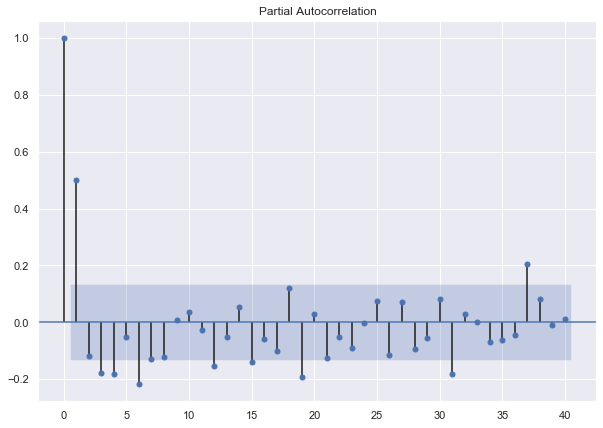

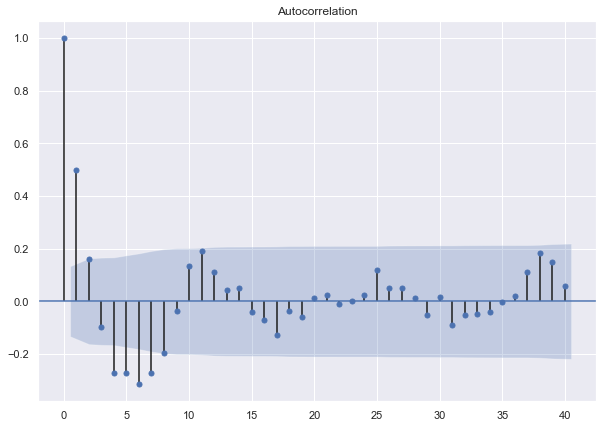

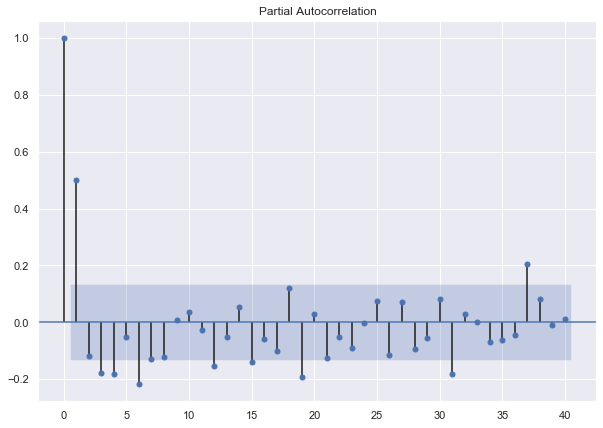

In [80]:
# visualize the residuals via correlations and confidence intervals
splt.plot_acf(milk_decomp.resid[6:-6], lags = 40)
splt.plot_pacf(milk_decomp.resid[6:-6], lags = 40)

## Evaluate via the ARMA Process

In [89]:
BIC, order, model = step_ARIMA(milk_decomp.resid[6:-6], 3, 0, 3)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Testing model of order: (0, 0, 1) with BIC = -1259.2535158002447
Testing model of order: (0, 0, 2) with BIC = -1263.389525817788
Testing model of order: (0, 0, 3) with BIC = -1261.658989020556
Testing model of order: (1, 0, 0) with BIC = -1266.3378712206202
Testing model of order: (1, 0, 1) with BIC = -1262.7075998773769
Testing model of order: (1, 0, 2) with BIC = -1259.395678185278
Testing model of order: (2, 0, 0) with BIC = -1263.7848721652163
Testing model of order: (2, 0, 1) with BIC = -1294.740052170152
Testing model of order: (2, 0, 2) with BIC = -1291.3156033726555
Testing model of order: (3, 0, 0) with BIC = -1265.063235537327
Testing model of order: (3, 0, 1) with BIC = -1291.2908263264492
***************************************
Best model with BIC = -1294.740052170152 and with order (2, 0, 1)


In [92]:
stepwise_fit = auto_arima(milk_decomp.resid[6:-6], start_p=0, start_q=0,
                          max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise
stepwise_fit.summary()

Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=-1116.415, BIC=-1106.461, Fit time=2.171 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=-1039.211, BIC=-1032.575, Fit time=0.097 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=-1118.641, BIC=-1105.369, Fit time=1.147 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-1156.207, BIC=-1142.934, Fit time=5.587 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=-1154.243, BIC=-1137.652, Fit time=5.348 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=-1074.902, BIC=-1064.948, Fit time=0.272 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=-1154.259, BIC=-1137.669, Fit time=14.038 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=-1152.475, BIC=-1132.567, Fit time=15.099 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=-1158.671, BIC=-1142.080, Fit time=5.386 seconds
Fit ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  216
Model:             SARIMAX(2, 0, 1)x(2, 1, 1, 12)   Log Likelihood                 591.449
Date:                            Thu, 26 Sep 2019   AIC                          -1166.897
Time:                                    13:11:49   BIC                          -1140.352
Sample:                                         0   HQIC                         -1156.159
                                            - 216                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2.659e-05      0.000      0.178      0.858      -0.000       0.000
ar.L1          1.1767      0.148      7.932      0.000       0.886       1.467
ar.L2         -0.5348      0.068     -7.840      0.000      -0.669      -0.401
ma.L1         -0.6126      0.169     -3.623      0.000      -0.944      -0.281
ar.S.L12      -0.1972      0.135     -1.456      0.146      -0.463       0.068
ar.S.L24      -0.2354      0.096     -2.444      0.015      -0.424      -0.047
ma.S.L12      -0.6752      0.107     -6.292      0.000      -0.886      -0.465
sigma2         0.0002   1.52e-05     10.912      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                       51.90   Jarque-Bera (JB):                 7.81
Prob(Q):                              0.10   Prob(JB):                         0.02
Heteroskedasticity (H):               0.75   Skew:                             0.13
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecast a Feature - Milk Production

### Normalize the Time Series Features

In [101]:
## Normalize the time series features
dairy_df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']] = dairy_df.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']].apply(zscore)

## Create dummy variables for the months
years = int(len(dairy_df['milk_log'])/12)
dairy_df.loc[:, 'Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * years
dummies = pd.get_dummies(dairy_df.loc[:, 'Month'])
dairy_df[list(dummies.columns)] = dummies
## Print the head of the data frame to look at the dummy variables.
dairy_df.head(12)

,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed,milk_log,Apr,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
1995-01-31,Jan,4.370,51.595,2.112,0.9803,-1.724471,-1.120740,-0.883649,0.747635,0,...,0,0,1,0,0,0,0,0,0,0
1995-02-28,Feb,3.695,56.086,1.932,0.8924,-1.709277,-1.120548,-0.883646,0.658556,0,...,0,1,0,0,0,0,0,0,0,0
1995-03-31,Mar,4.538,68.453,2.162,0.8924,-1.694084,-1.120226,-0.883641,0.771034,0,...,0,0,0,0,0,1,0,0,0,0
1995-04-30,Apr,4.280,65.722,2.130,0.8967,-1.678890,-1.119776,-0.883630,0.756122,1,...,0,0,0,0,0,0,0,0,0,0
1995-05-31,May,4.470,73.730,2.227,0.8967,-1.663696,-1.119198,-0.883612,0.800655,0,...,0,0,0,0,0,0,1,0,0,0
1995-06-30,Jun,4.238,77.994,2.124,0.9160,-1.648503,-1.118491,-0.883585,0.753301,0,...,0,0,0,0,1,0,0,0,0,0
1995-07-31,Jul,4.377,81.475,2.184,0.9160,-1.633309,-1.117656,-0.883547,0.781158,0,...,0,0,0,1,0,0,0,0,0,0
1995-08-31,Aug,4.368,74.981,2.152,0.8934,-1.618116,-1.116692,-0.883497,0.766398,0,...,0,0,0,0,0,0,0,0,0,0
1995-09-30,Sep,3.917,61.530,2.062,0.8934,-1.602922,-1.115600,-0.883433,0.723676,0,...,0,0,0,0,0,0,0,0,0,1
1995-10-31,Oct,4.078,60.022,2.121,0.9434,-1.587729,-1.114379,-0.883353,0.751888,0,...,0,0,0,0,0,0,0,0,1,0


### Establish a Linear Regression Model

In [124]:
endDate = '12-31-2012'
startDate = endDate
X = dairy_df.loc[:endDate, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values
Y = dairy_df.loc[:endDate, 'milk_log'].values
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)

## and the predictions and the residual
dairy_df.loc[:endDate, 'scores'] = mod_fit.predict(X)
dairy_df.loc[:endDate, 'resids'] = dairy_df.loc[:endDate, 'scores'] - dairy_df.loc[:endDate, 'milk_log']

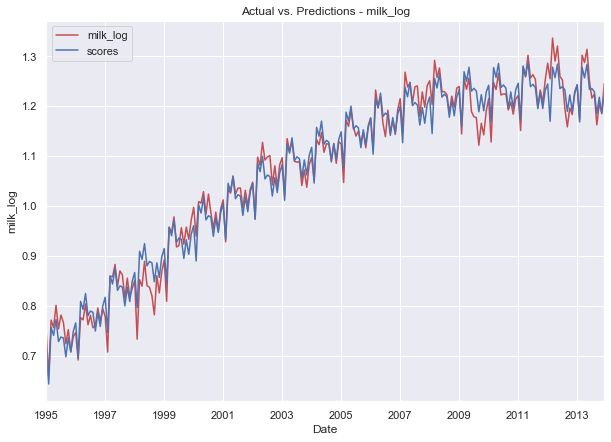

In [128]:
# plot the linear regression result
plot_mod_fit(dairy_df, 'milk_log')

> Evaluate the RMSE of the seasonal predictions upon the remaining 12-month time series.

In [121]:
## Make the forecast for the next year
X = dairy_df.loc[startDate:, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values
rmse = RMSE(dairy_df.loc[startDate:, 'milk_log'].values, mod_fit.predict(X))
print('RMSE: {}'.format(rmse))

RMSE: 0.13524126222368962


> Evaluate the residuals.

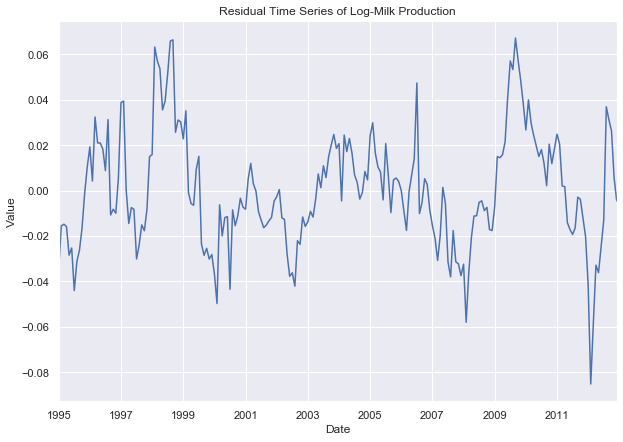

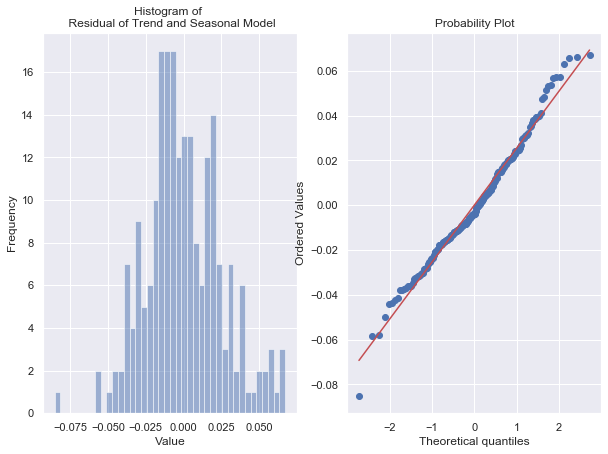

In [136]:
plot_ts(dairy_df.loc[:endDate, 'resids'], title = 'Residual Time Series of Log-Milk Production')
dist_ts(dairy_df.loc[:endDate, 'resids'], '\n Residual of Trend and Seasonal Model')

In [140]:
# determine that the residuals are stationary or not
DF_Test(dairy_df.loc[:endDate, 'resids'].values)

D-F statistic = -4.629902367773542
p-value = 0.00011373279240862235
number of lags used = 0
Critical value at 5% confidence = -2.875078880098608
Critical value at 10% confidence = -2.5739861168199027


In [141]:
# apply the ARIMA model
BIC, order, model_fit = step_ARIMA(dairy_df.loc[:endDate, 'resids'], 4, 3, 4)    
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

Testing model of order: (0, 0, 1) with BIC = -1103.488642827565
Testing model of order: (0, 0, 2) with BIC = -1147.8577829473888
Testing model of order: (0, 0, 3) with BIC = -1178.1580917838369
Testing model of order: (0, 0, 4) with BIC = -1177.0042964063039
Testing model of order: (0, 1, 1) with BIC = -1189.0253273257224
Testing model of order: (0, 1, 2) with BIC = -1184.7026263574312
Testing model of order: (0, 1, 3) with BIC = -1180.7590742942596
Testing model of order: (0, 1, 4) with BIC = -1178.823078365838
Testing model of order: (0, 2, 1) with BIC = -1173.4669587238216
Testing model of order: (1, 0, 0) with BIC = -1209.6064524461387
Testing model of order: (1, 0, 1) with BIC = -1204.5577163647915
Testing model of order: (1, 0, 2) with BIC = -1199.280168934748
Testing model of order: (1, 0, 3) with BIC = -1193.924690524659
Testing model of order: (1, 0, 4) with BIC = -1189.5470817403097
Testing model of order: (1, 1, 0) with BIC = -1188.5917739983854
Testing model of order: (1, 1

C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing model of order: (1, 2, 2) with BIC = -1173.618232693857
Testing model of order: (1, 2, 3) with BIC = -1161.9264968529485
Testing model of order: (2, 0, 0) with BIC = -1204.5726170928674
Testing model of order: (2, 0, 1) with BIC = -1199.22863634764
Testing model of order: (2, 0, 2) with BIC = -1193.9075274790248
Testing model of order: (2, 0, 3) with BIC = -1189.6750244322227
Testing model of order: (2, 0, 4) with BIC = -1186.1581313342208
Testing model of order: (2, 1, 0) with BIC = -1183.9146276085612
Testing model of order: (2, 1, 1) with BIC = -1190.7828478595513
Testing model of order: (2, 1, 2) with BIC = -1185.1441753610186
Testing model of order: (2, 2, 0) with BIC = -1101.0243215270093
Testing model of order: (2, 2, 1) with BIC = -1166.3055681784258
Testing model of order: (2, 2, 2) with BIC = -1161.7686158797057


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (2, 2, 3) with BIC = -1169.883973834008


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (2, 2, 4) with BIC = -1157.3212820338426
Testing model of order: (3, 0, 0) with BIC = -1199.2661566171737
Testing model of order: (3, 0, 1) with BIC = -1193.8915277470296
Testing model of order: (3, 0, 2) with BIC = -1198.2435892760575
Testing model of order: (3, 0, 3) with BIC = -1186.1070015581888
Testing model of order: (3, 0, 4) with BIC = -1181.6926442715605
Testing model of order: (3, 1, 0) with BIC = -1179.4869234924279
Testing model of order: (3, 1, 1) with BIC = -1185.4505030479115
Testing model of order: (3, 1, 2) with BIC = -1180.7388238426233
Testing model of order: (3, 2, 0) with BIC = -1104.9509574960666
Testing model of order: (3, 2, 1) with BIC = -1161.7584230976715
Testing model of order: (3, 2, 2) with BIC = -1156.4027924668844


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing model of order: (3, 2, 3) with BIC = -1153.7780180849386


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (3, 2, 4) with BIC = -1149.837948722821
Testing model of order: (4, 0, 0) with BIC = -1193.8967294058937
Testing model of order: (4, 0, 1) with BIC = -1190.1867452844665
Testing model of order: (4, 0, 2) with BIC = -1199.1307817653155
Testing model of order: (4, 0, 3) with BIC = -1189.465884414412
Testing model of order: (4, 0, 4) with BIC = -1185.152528978458
Testing model of order: (4, 1, 0) with BIC = -1178.357502605497
Testing model of order: (4, 1, 1) with BIC = -1174.4355692556232
Testing model of order: (4, 1, 2) with BIC = -1169.130531603256


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


Testing model of order: (4, 1, 3) with BIC = -1177.7735235688285
Testing model of order: (4, 1, 4) with BIC = -1162.045199502832
Testing model of order: (4, 2, 0) with BIC = -1125.791550311693
Testing model of order: (4, 2, 1) with BIC = -1160.373663333985
Testing model of order: (4, 2, 2) with BIC = -1156.5377314386687
Testing model of order: (4, 2, 3) with BIC = -1151.2649129395238
Testing model of order: (4, 2, 4) with BIC = -1150.1993075636185
Best order = (1, 0, 0) best BIC = -1209.6064524461387


C:\Users\NateDogg\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


### Make Predictions on the Residuals

In [142]:
start_index = len(dairy_df.loc[:endDate, 'resids'])
end_index = start_index + 12
model_prediction = model_fit.predict(start=start_index, end=end_index)
model_prediction

2013-01-31   -0.003742
2013-02-28   -0.003087
2013-03-31   -0.002546
2013-04-30   -0.002100
2013-05-31   -0.001732
2013-06-30   -0.001429
2013-07-31   -0.001179
2013-08-31   -0.000972
2013-09-30   -0.000802
2013-10-31   -0.000661
2013-11-30   -0.000546
2013-12-31   -0.000450
2014-01-31   -0.000371
Freq: M, dtype: float64

In [144]:
## Make the forecast for the next year
X = dairy_df.loc[startDate:, ['Month.Count', 'monthNumSqred', 'monthNumCubed', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']].values
## and the predictions for the forecast
dairy_df.loc[startDate:, 'scores'] =  mod_fit.predict(X) - model_prediction

RMSE: 0.23557847612453575


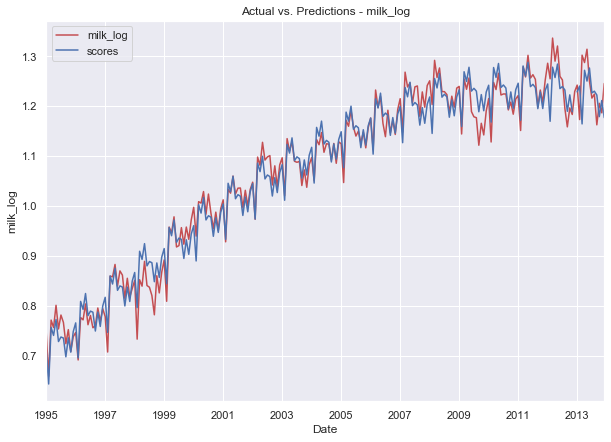

In [147]:
plot_mod_fit(dairy_df, 'milk_log')
rmse = RMSE(dairy_df.loc[startDate:, 'milk_log'].values, dairy_df.loc[startDate:, 'scores'])
#        RMSE(CBE.loc['1989-12-31':, 'elec_log'].as_matrix(), CBE.loc['1989-12-31':, 'scores'])
print('RMSE: {}'.format(rmse))

### Assess the Correlations - Auto and Partial

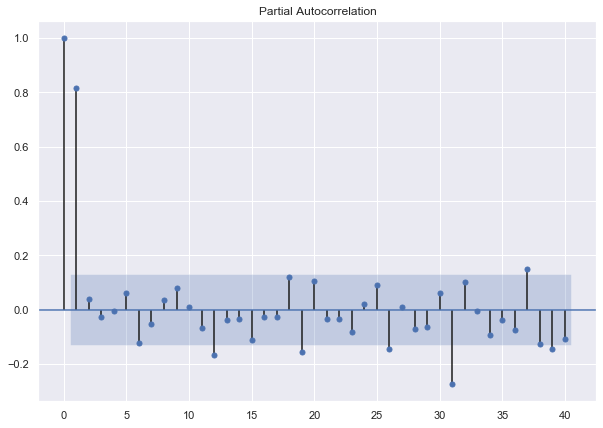

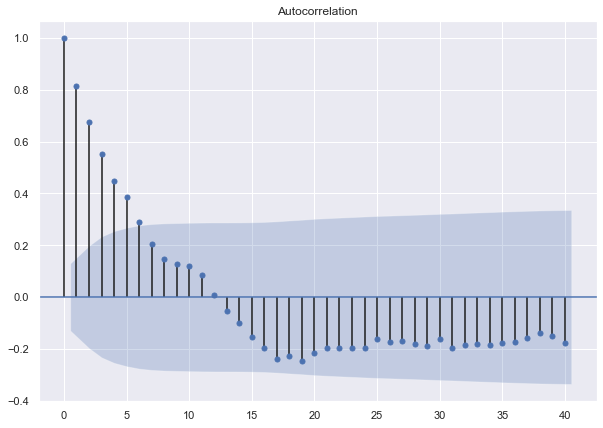

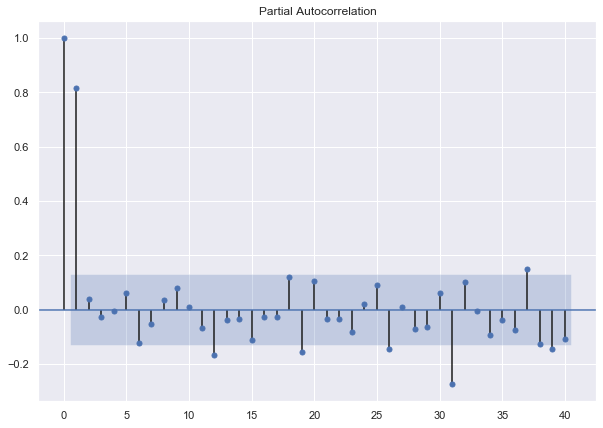

In [148]:
# visualize the residuals via correlations and confidence intervals
splt.plot_acf(dairy_df['resids'], lags = 40)
splt.plot_pacf(dairy_df['resids'], lags = 40)

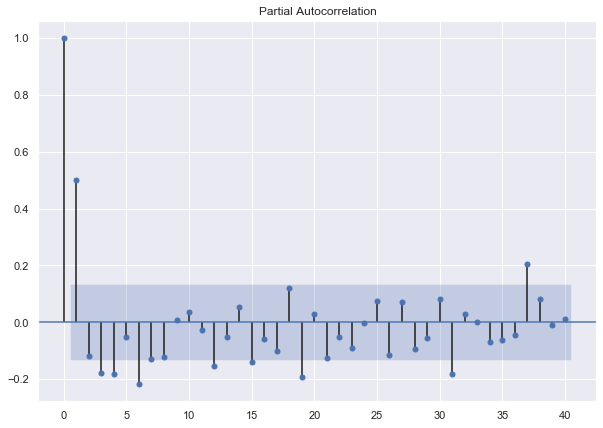

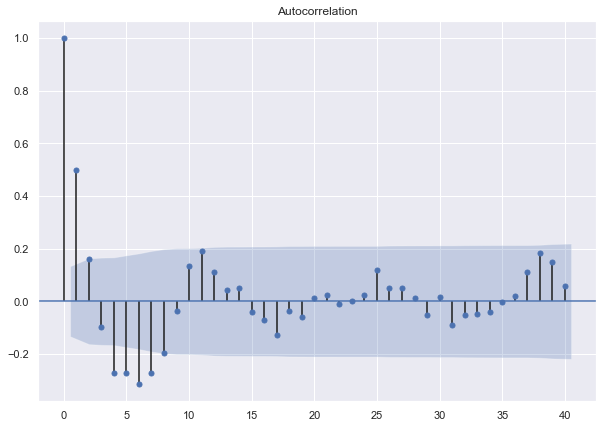

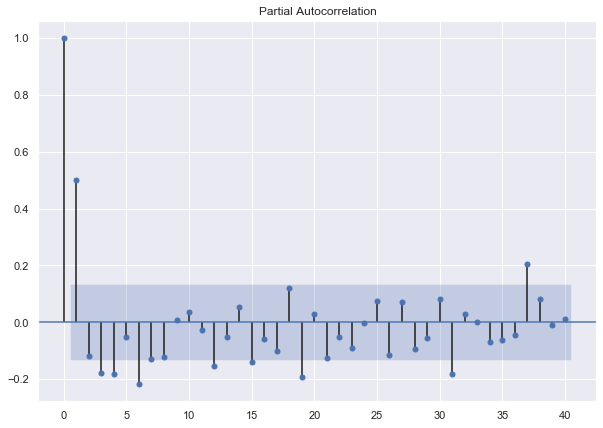

In [149]:
splt.plot_acf(milk_decomp.resid[6:-6], lags = 40)
splt.plot_pacf(milk_decomp.resid[6:-6], lags = 40)

## Question Responses

> Is this time series stationary?  
> - The time series for Milk production is not stationary, as the plot result shows a positive trend, primarily near the middle of the time series data.

> Is there a significant seasonal component?  
> - There is a significant seasonal component, where at the beginning of each year a spike in production is observed that trends downward across the year, with an overall positive trend from year to year.  

> For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?  
> - The best fit model via the ARMA method is ARMA(2, 1).  
> - This is further verified via the auto_arima (pyramid) process, as shown below the initial results, where the BIC value has been minimized upon convergance. 

Forecast production for 12 months and:  
1. Report both numeric values.
2. Plot the confidence intervals.

> 1. RMSE_(Linear Regression Model)  
>    0.13524126222368962  
> <br>
> 2. RMSE_(ARIMA)  
>    0.23557847612453575  
> <br>  
> ***NOTE:*** per the instructional lab for this lesson 8, a larger RMSE score is considered a better fit than the lower score. This is not intuitive, and my research indicates this conclusion is contrary to popular perspective on the matter. 

> Are the confidence intervals reasonably small compared to the forecast means?  
> - The confiedence intervals returned from the auto-correlation and partial auto-correlation functions give reasonably small magnitudes compared to the forecast means. 

> How do the confidence intervals behave as time moves to the future?  
>   - The partial auto-correlation function returns a constant value for all x-values of the time series.  
>   - The auto-correlation behavior is somewhat different as time increases, where upon inspection of these plots, the confidence intervals vary and increase as time increases.